In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
import datetime
import math

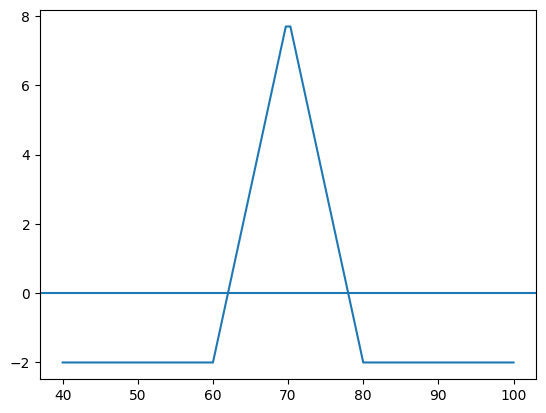

In [ ]:
'''
Calculates profit for iron butterfly
Input: pandas Series representing 4 options trades, with indices 'lower_strike',
'mid_put','mid_call','upper_strike','otm_put_price','otm_call_price',
'atm_put_price','atm_call_price'

Input: price of the underlying on the expiration date

Returns: profit
'''

def calculate_iron_butterfly(trade, underlying_price):
  if (underlying_price < trade['mid_put']): # ATM put
    atm_put = trade['atm_put_price'] + underlying_price - trade['mid_put']
  else:
    atm_put = trade['atm_put_price']
  if (underlying_price > trade['mid_call']): # ATM call
    atm_call = trade['atm_call_price'] + trade['mid_call'] - underlying_price
  else:
    atm_call = trade['atm_call_price']
  if (underlying_price < trade['lower_strike']): # OTM put
    otm_put = trade['lower_strike'] - underlying_price - trade['otm_put_price']
  else:
    otm_put = -trade['otm_put_price']
  if (underlying_price > trade['upper_strike']): # OTM call
    otm_call = underlying_price - trade['upper_strike'] - trade['otm_call_price']
  else:
    otm_call = -trade['otm_call_price']
  return atm_put + atm_call + otm_put + otm_call


# Example: buy OTM put @ 60 and OTM call @ 80 for $1 each,
#          sell ATM call/put @ 70 for $5 each
sample_data = {}
x = np.linspace(40, 100, 100)
y = [calculate_iron_butterfly(trade=pd.Series(data={'lower_strike':60,
    'mid_put':70,'mid_call':70, 'upper_strike':80, 'otm_put_price':1,
    'otm_call_price':1, 'atm_put_price':5,'atm_call_price':5},
    index=['lower_strike','mid_put','mid_call','upper_strike','otm_put_price','otm_call_price',
           'atm_put_price','atm_call_price']), underlying_price=z) for z in x]
plt.plot(x, y)
plt.axhline(y = 0)

In [ ]:
vix_ticker = yf.Ticker("^VIX")

# Fetch VIX data
vix_data = pd.DataFrame(vix_ticker.history(start="2023-04-03", end="2023-06-30"))
vix_data.index = [str(date.to_pydatetime())[:10] for date in vix_data.index]

# Fetch SPX options data
spx_data = pd.read_csv("./sample_data/combined_SPX_with_price.csv")

In [ ]:
iron_butterfly_trades = pd.DataFrame(index = vix_data.index)

# pick an expiration date (all expiration dates are 3rd Friday of each month,
# so we'll still have a lot of data to work with)
# iron butterfly requires all 4 options to expire on the same day

expiration_date = '2023-09-15'

# filter spx data into calls and puts, and make sure that there is bid and ask volume
# also make sure that it expires before 12/5/2023 (we can't get data from the future)
calls = spx_data.query('Option_Type == "C" and bid_sz_00 != 0 and ask_sz_00 != 0 and Expiration_Date == @expiration_date')
puts = spx_data.query('Option_Type == "P" and bid_sz_00 != 0 and ask_sz_00 != 0 and Expiration_Date == @expiration_date')

for curr_date in vix_data.index:

  unable_to_find = False

  #curr_date = str(curr_date.to_pydatetime())[:10]
  daily_calls = calls.query('date == @curr_date')
  daily_puts = puts.query('date == @curr_date')

  underlying_price = daily_calls.iloc[0]['close'] # strike price of the ATM call/put (current share price)
  iron_butterfly_trades.at[curr_date,'underlying_price'] = underlying_price

  # mid is the middle of the spread, floored to the nearest multiple of 10

  mid = underlying_price / 10
  mid = math.floor(mid)
  mid *= 10

  # look for the best ATM call bid (with strike price close to mid)

  daily_calls_atm = daily_calls.query('Strike_Price >= @mid - 10 and Strike_Price <= @mid + 10')
  if (not daily_calls_atm.empty):
    best_index = daily_calls_atm['Strike_Price'].idxmax()
    mid_call = daily_calls_atm.at[best_index,'Strike_Price']
    atm_call_price = daily_calls_atm.at[best_index,'bid_px_00'] * 0.000000001

    iron_butterfly_trades.at[curr_date,'mid_call'] = mid_call
    iron_butterfly_trades.at[curr_date,'atm_call_price'] = atm_call_price
  else:
    unable_to_find = True

  # look for the best ATM put bid

  daily_puts_atm = daily_puts.query('Strike_Price >= @mid - 10 and Strike_Price <= @mid + 10')

  if (not daily_puts_atm.empty):
    best_index = daily_puts_atm['Strike_Price'].idxmax()
    mid_put = daily_puts_atm.at[best_index,'Strike_Price']
    atm_put_price = daily_puts_atm.at[best_index,'bid_px_00'] * 0.000000001

    iron_butterfly_trades.at[curr_date,'mid_put'] = mid_put
    iron_butterfly_trades.at[curr_date,'atm_put_price'] = atm_put_price
  else:
    unable_to_find = True

  # look for the cheapest OTM put (with Strike_Price = underlying_price - 300, +- 50)

  daily_puts_otm = daily_puts.query('Strike_Price >= @mid - 350 and Strike_Price <= @mid - 250')

  if (not daily_puts_otm.empty):
    best_index = daily_puts_otm['Strike_Price'].idxmin()
    lower_strike = daily_puts_otm.at[best_index,'Strike_Price']
    otm_put_price = daily_puts_otm.at[best_index,'ask_px_00'] * 0.000000001

    iron_butterfly_trades.at[curr_date,'lower_strike'] = lower_strike
    iron_butterfly_trades.at[curr_date,'otm_put_price'] = otm_put_price
  else:
    unable_to_find = True

  # look for the cheapest OTM call (with Strike_Price = underlying_price + 300, +- 50)

  daily_calls_otm = daily_calls.query('Strike_Price <= @mid + 350 and Strike_Price >= @mid + 250')

  if (not daily_calls_otm.empty):
    best_index = daily_calls_otm['Strike_Price'].idxmin()
    upper_strike = daily_calls_otm.at[best_index,'Strike_Price']
    otm_call_price = daily_calls_otm.at[best_index,'ask_px_00'] * 0.000000001

    iron_butterfly_trades.at[curr_date,'upper_strike'] = upper_strike
    iron_butterfly_trades.at[curr_date,'otm_call_price'] = otm_call_price
  else:
    unable_to_find = True

  # if we couldn't find ATM call/put or OTM call/put reasonably close to the target price, drop the row
  if (unable_to_find):
    iron_butterfly_trades = iron_butterfly_trades.drop(curr_date, axis='rows')


In [ ]:
# Backtest the strategy, one iron butterfly per day
# Actual price of underlying on expiration date: 8/18/2023: 4369.71 | 9/15/2023: 4450.32

underlying_price = {'2023-08-18': 4369.71, '2023-09-15': 4450.32}

iron_butterfly_trades['profit'] = iron_butterfly_trades.apply(calculate_iron_butterfly, axis=1, underlying_price = underlying_price[expiration_date])

In [ ]:
# Append VIX data to the dataframe

result = pd.merge(iron_butterfly_trades, vix_data['Open'], left_index=True, right_index=True)
result.to_csv('result.csv')